In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_sw
#nltk.download('popular')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score

####################################################################################

# Class with a callable method used by TfidfVectorizer to tokenize the document
class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def __call__(self, document):
        lemmas = []
        
        document = document.replace("[^a-zA-z\s]","")
        for t in word_tokenize(document):
            t = t.strip()
            lemma = self.lemmatizer.lemmatize(t)
            
            if len(lemma) > 3:
                lemmas.append(lemma)
        return lemmas

# Main class of the project. Contains method for loading the datasets, train the models and test it
class WineRegressionTask:
    def __init__(self):
        lemmaTokenizer = LemmaTokenizer()                

        # ColumnTransformer is a sort of pipeline that apply some transformation to the given columns.
        # In our case, it performs OHE and TF-IDF.
        # The columns that are not mentioned are dropped.
        self.col_transf_model = ColumnTransformer(
                                                    transformers=[
                                                        # handle_unknown is mandatory since we don't know if in the evaluation set (ES) there are different unique values
                                                        # from the development set (DS). In this way we discard the error.
                                                        # If a new unique value is founded in ES this is not encoded since both the ES and DS must have the same dimension.
                                                        # On the other hand can happen that a values in the DS and not in ES. The resulting row will have all 0's.
                                                        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), [
                                                                                                           "country", 
                                                                                                           "province", 
                                                                                                           "variety", 
                                                                                                           "winery",
                                                                                                           "region_1",
                                                                                                           "designation"
                                                                                                          ]),
                                                        ('tfidf', TfidfVectorizer(stop_words=nltk_sw.words('english'), tokenizer=lemmaTokenizer), "description"),
                                                    ],
                                                    remainder='drop',
                                                    n_jobs=-1
                                                  )
        
    
    # Method that load the datasets (dev and eval)
    def load_dataset(self, path_dev, path_eval):
        self.df_dev = pd.read_csv(path_dev, sep='\t')
        self.df_eval = pd.read_csv(path_eval, sep='\t')
    
    # Method that performs all the preprocessing on our data
    def preprocessing(self):
        self.df_dev.drop_duplicates(inplace=True)
        
        self.y_true = self.df_dev["quality"]
        self.df_dev.drop(columns=["quality"], inplace=True)

        self.df_dev.fillna("", inplace=True)
        self.df_eval.fillna("", inplace=True)

        for d, e in zip(self.df_dev.columns, self.df_eval.columns):
            self.df_dev[d] = self.df_dev[d].str.lower()
            self.df_eval[e] = self.df_eval[e].str.lower()

        # We fit and transform our ColumnTransformer on the DS
        self.processed_data = self.col_transf_model.fit_transform(self.df_dev)
        # and we only trasform the ES
        self.eval_data = self.col_transf_model.transform(self.df_eval)     

        print(f"DF_DEV dimension before preprocessing: {self.df_dev.shape}")
        print(f"DF_DEV dimension after preprocessing: {self.processed_data.shape}\n")
        
        print(f"DF_EVAL dimension before preprocessing: {self.df_eval.shape}")
        print(f"DF_EVAL dimension after preprocessing: {self.eval_data.shape}\n")
        
        
    # Method that train the models with the default parameter. Accepted values for p are:
    #      - RF, if you want to train a RandomForestRegressor model;
    #      - L, if you want to train a Lasso regression model;
    #      - R, if you want to train a Ridge regression model;
    #      - SVR, if you want to train a SupportVectorRegressor model.
    # Note that the develompment set is splitted in 80/20 train/test.
    def default_model_train(self, p):
        X_train, X_test, y_train, y_test = train_test_split(self.processed_data, self.y_true, test_size=0.2, random_state=42, shuffle=True)
        
        if p == "RF":
            self.model = RandomForestRegressor(n_jobs=-1, random_state=42, verbose=3)
        elif p == "L":
            self.model = Lasso(random_state=42)
        elif p == "R":
            self.model = Ridge(random_state=42)
        elif p == "SVR":
            self.model = SVR()
            
        self.model.fit(X_train, y_train)
        self.y_pred = self.model.predict(X_test)
        print("##### R2 SCORE on test:")
        print(r2_score(y_test, self.y_pred))
        print("\n")
        
    
    # Method that start an hyperparamenters tuning using the Gridsearch function on RanfomForest and Ridge. 
    # Accepted values for p are:
    #      - RF, if you want to tune the parameter for RandomForestRegressor;
    #      - RIDGE, if you want to tune the parameter for Ridge regression;
    # Note that the develompment set is splitted in 80/20 train/test.
    def gridsearch_model_train(self, p): 
        print(f"DF_DEV dimension: {self.processed_data.shape}")
        X_train, X_test, y_train, y_test = train_test_split(self.processed_data, self.y_true, test_size=0.2, random_state=42, shuffle=True)
        
        if p == "RF":
            pipe = Pipeline([
                                ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
                            ])
        
            param_grid = {
                            'model__n_estimators': [100, 200],
                            'model__min_samples_split': [2, 10, 20]
                         }
            
        elif p == "RIDGE":
            pipe = Pipeline([
                                ('model', Ridge(random_state=42))
                            ])

            param_grid = {
                            'model__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            'model__fit_intercept': [True, False]
                          }
        
        # Gridsearch with cross validation with number of fold = 5 for finding the best hyperparameter configuration based on R2 score. 
        # (verbose helps to follow the progress since it prints on the screen the current status)
        self.gridsearch = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, verbose=10)
        self.gridsearch.fit(X_train, y_train)
        
        print("\n***** Gridsearch best score:")
        print(self.gridsearch.best_params_)
        print("\n***** Gridsearch best score:")
        print(self.gridsearch.best_score_)
        print("\n")
        
        self.y_pred = self.gridsearch.predict(X_test)        
        print("##### R2 SCORE on test:")
        print(r2_score(y_test, self.y_pred))
        print("\n")
        
    # Method that predict the quality of the wine contained in the evaluation dataset and store the result in a .csv file
    # Accepted values for p are:
    #      - D (default), if you want to evalute your default parameter model;
    #      - GS (gridsearch), if you want to evalute your gridserch best model;
    def regression(self, p): 
        if p == "D":
            y_pred = self.model.predict(self.eval_data)
            pd.DataFrame(y_pred).to_csv("./output/output_defaultTrain.csv", index_label="Id", header=["Predicted"])
        elif p == "GS":
            y_pred = self.gridsearch.predict(self.eval_data)
            pd.DataFrame(y_pred).to_csv("./output/output.csv", index_label="Id", header=["Predicted"])

## 1. Dataset loading and preprocessing

In [13]:
%%time
wrt = WineRegressionTask()

wrt.load_dataset("dev.tsv","eval.tsv")
wrt.preprocessing()

DF_DEV dimension before preprocessing: (85028, 8)
DF_DEV dimension after preprocessing: (85028, 81890)

DF_EVAL dimension before preprocessing: (30186, 8)
DF_EVAL dimension after preprocessing: (30186, 81890)

Wall time: 2min 13s


## 2. Model selection

In [ ]:
%%time
# Too long, don't run it

# wrt.default_model_train("SVR")
# wrt.regression("D")

In [8]:
%%time
wrt.default_model_train("RF")
# wrt.regression("D")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100


building tree 5 of 100building tree 6 of 100
building tree 7 of 100
building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.2min


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s


##### R2 SCORE on test:
0.5574633543093401


Wall time: 26min 19s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [6]:
%%time
wrt.default_model_train("L")
# wrt.regression("D")

##### R2 SCORE on test:
-4.159064364994691e-05


Wall time: 13.5 s


In [14]:
%%time
wrt.default_model_train("R")
wrt.regression("D")

##### R2 SCORE on test:
0.748827247336932


Wall time: 4.72 s


## 3. Hyperparameter tuning and results

In [ ]:
%%time
wrt.gridsearch_model_train("RF")
wrt.regression("GS")

# Output lost. Gridsearch process needs 7/8h to finish. Result in report.

In [9]:
%%time
wrt.gridsearch_model_train("RIDGE")
wrt.regression("GS")

DF_DEV dimension: (85028, 81890)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] model__alpha=0.1, model__fit_intercept=True .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__alpha=0.1, model__fit_intercept=True, score=0.711, total=   9.5s
[CV] model__alpha=0.1, model__fit_intercept=True .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=True, score=0.703, total=   9.6s
[CV] model__alpha=0.1, model__fit_intercept=True .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=True, score=0.707, total=   9.5s
[CV] model__alpha=0.1, model__fit_intercept=True .....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.6s remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=True, score=0.693, total=   9.4s
[CV] model__alpha=0.1, model__fit_intercept=True .....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.9s remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=True, score=0.705, total=   9.5s
[CV] model__alpha=0.1, model__fit_intercept=False ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.4s remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=False, score=0.710, total=   7.7s
[CV] model__alpha=0.1, model__fit_intercept=False ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   55.1s remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=False, score=0.703, total=   7.8s
[CV] model__alpha=0.1, model__fit_intercept=False ....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.0min remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=False, score=0.706, total=   7.6s
[CV] model__alpha=0.1, model__fit_intercept=False ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=False, score=0.691, total=   7.9s
[CV] model__alpha=0.1, model__fit_intercept=False ....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV]  model__alpha=0.1, model__fit_intercept=False, score=0.702, total=   7.8s
[CV] model__alpha=0.2, model__fit_intercept=True .....................
[CV]  model__alpha=0.2, model__fit_intercept=True, score=0.730, total=   6.9s
[CV] model__alpha=0.2, model__fit_intercept=True .....................
[CV]  model__alpha=0.2, model__fit_intercept=True, score=0.725, total=   7.2s
[CV] model__alpha=0.2, model__fit_intercept=True .....................
[CV]  model__alpha=0.2, model__fit_intercept=True, score=0.729, total=   7.2s
[CV] model__alpha=0.2, model__fit_intercept=True .....................
[CV]  model__alpha=0.2, model__fit_intercept=True, score=0.714, total=   6.9s
[CV] model__alpha=0.2, model__fit_intercept=True .....................
[CV]  model__alpha=0.2, model__fit_intercept=True, score=0.725, total=   7.0s
[CV] model__alpha=0.2, model__fit_intercept=False ....................
[CV]  model__alpha=0.2, model__fit_intercept=False, score=0.729, total=   5.8s
[CV] model__alpha=0.2, mod

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.5min finished



***** Gridsearch best score:
{'model__alpha': 0.8, 'model__fit_intercept': True}

***** Gridsearch best score:
0.7417532508461885


##### R2 SCORE on test:
0.7493981560371423


Wall time: 7min 35s


## --------------------------------------------------------------------------------------------------------------------------------------

## (EXTRA)  Report graph generation 

In [ ]:
GSresult = pd.DataFrame(wrt.gridsearch.cv_results_)
GSresult.to_csv("gs_ridge_final.csv")

graph = GSresult[["mean_fit_time", "params", "mean_test_score"]].copy()
graph["params"] = graph["params"].astype("string").str.replace("[{}]", "")
graph["params"] = graph["params"].str.replace("model__", "")
graph["params"] = graph["params"].str.replace(", ", "\n")

graph.head()

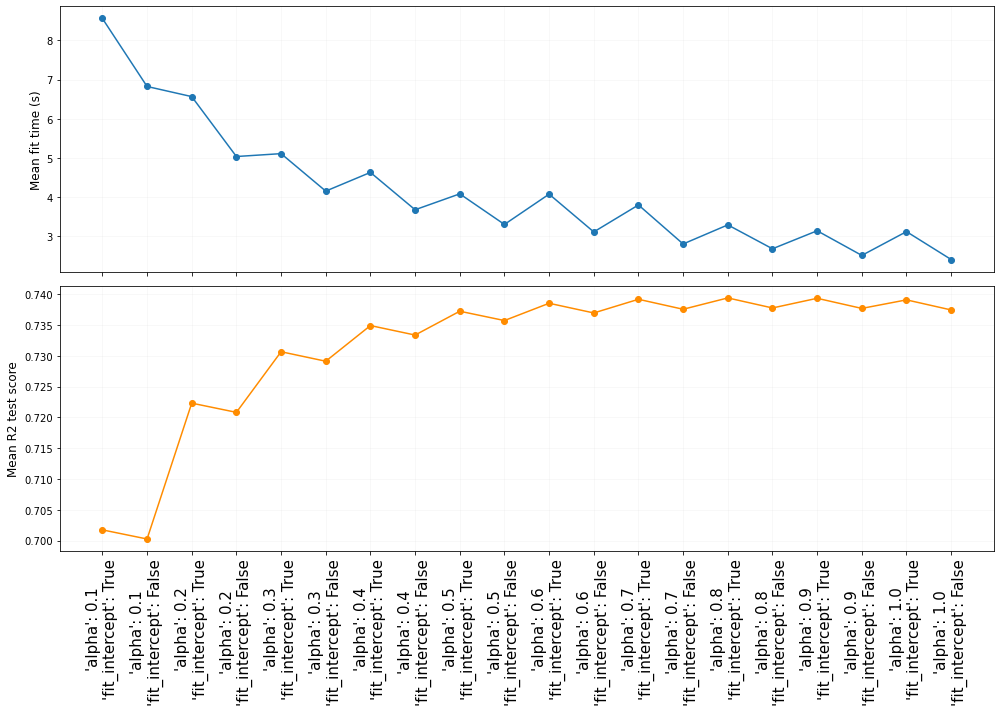

In [194]:
fig, ax = plt.subplots(2, 1, figsize=(14,10), sharex=True)

ax[1].set_xticks(graph.index) 
ax[1].set_xticklabels(graph["params"], fontsize=15, rotation='vertical')

ax[0].set_ylabel('Mean fit time (s)', fontsize='large')
ax[1].set_ylabel('Mean R2 test score', fontsize='large')
ax[0].grid(alpha=0.1)
ax[1].grid(alpha=0.1)

ax[0].plot(graph["mean_fit_time"], marker='o', linestyle='-')
ax[1].plot(graph["mean_test_score"], marker='o', linestyle='-', c='darkorange')
plt.tight_layout()

fig.savefig("gridsearch_cv_ridge.pdf")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

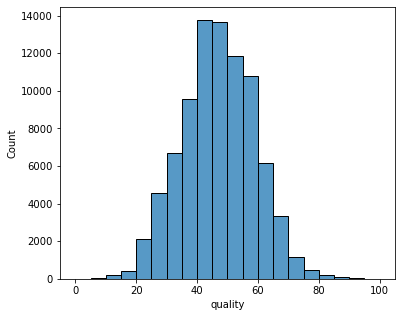

In [255]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(wrt.y_true, bins=20, ax=ax)
plt.savefig("quality_displot.eps")